# Proyecto 4: Pipeline de preprocesamiento

## Objetivo
Crear 3 pipelines para 5,000 oraciones:
- (a) crudo
- (b) normalizado (minúsculas, sin puntuación)
- (c) normalizado+lematizado (spaCy ES)

## Historias de usuario
- Como analista de texto, quiero comparar pipelines para reducir OOV sin perder información
- Como investigador, necesito métricas de vocabulario para optimizar preprocesamiento

## Setup reproducible

In [7]:
# Seeds para reproducibilidad
import random
import numpy as np
random.seed(42)
np.random.seed(42)

# Imports básicos
import pandas as pd
import matplotlib.pyplot as plt
import spacy
import re
from collections import Counter

print("Setup completo")

Setup completo


## Carga de datos

In [8]:
# Cargar dataset y tomar 5,000 oraciones
df = pd.read_csv('dataset/nlp_prueba_cc0c2_large.csv')
textos = df['Texto'].head(5000).tolist()

print(f"Oraciones cargadas: {len(textos)}")
print(f"Ejemplo: {textos[0]}")

Oraciones cargadas: 5000
Ejemplo: La tokenización es clave para procesar texto


## Pipelines

In [9]:
# (a) Pipeline crudo
def pipeline_crudo(texto):
    """Tokenización básica por espacios"""
    return texto.split()

# (b) Pipeline normalizado
def pipeline_normalizado(texto):
    """Minúsculas + sin puntuación"""
    # minúsculas
    texto = texto.lower()
    # quitar puntuación
    texto = re.sub(r'[.,;:!?()\[\]{}"\']', '', texto)
    return texto.split()

print("Pipelines definidos")

Pipelines definidos


In [10]:
# (c) Pipeline con spaCy
nlp = spacy.load('es_core_news_sm')

def pipeline_spacy(texto):
    """Normalizado + lematizado"""
    # normalizar primero
    texto = texto.lower()
    texto = re.sub(r'[.,;:!?()\[\]{}"\']', '', texto)
    
    # procesar con spaCy
    doc = nlp(texto)
    lemmas = [token.lemma_ for token in doc if not token.is_space]
    return lemmas

print("Pipeline spaCy listo")

Pipeline spaCy listo


## Procesamiento de textos

In [11]:
# Procesar con los 3 pipelines
print("Procesando 5,000 oraciones...")

# Pipeline (a) crudo
tokens_crudo = []
for texto in textos:
    tokens_crudo.extend(pipeline_crudo(texto))

# Pipeline (b) normalizado
tokens_norm = []
for texto in textos:
    tokens_norm.extend(pipeline_normalizado(texto))

print(f"Pipeline crudo: {len(tokens_crudo)} tokens")
print(f"Pipeline normalizado: {len(tokens_norm)} tokens")

Procesando 5,000 oraciones...
Pipeline crudo: 40140 tokens
Pipeline normalizado: 40140 tokens


In [12]:
# Pipeline (c) spaCy - más lento
print("Procesando con spaCy...")
tokens_spacy = []
for i, texto in enumerate(textos):
    if i % 1000 == 0:
        print(f"Procesadas: {i}")
    tokens_spacy.extend(pipeline_spacy(texto))

print(f"Pipeline spaCy: {len(tokens_spacy)} tokens")

Procesando con spaCy...
Procesadas: 0
Procesadas: 1000
Procesadas: 2000
Procesadas: 3000
Procesadas: 4000
Pipeline spaCy: 40140 tokens


## Vocabularios y métricas

In [18]:
# Calcular vocabularios
vocab_crudo = set(tokens_crudo)
vocab_norm = set(tokens_norm)
vocab_spacy = set(tokens_spacy)

print(f"Vocabulario crudo: {len(vocab_crudo)} tokens únicos")
print(f"Vocabulario normalizado: {len(vocab_norm)} tokens únicos")
print(f"Vocabulario spaCy: {len(vocab_spacy)} tokens únicos")

# Ejemplos de tokens
print(f"\nEjemplos crudo: {list(vocab_crudo)[:10]}")
print(f"Ejemplos normalizado: {list(vocab_norm)[:10]}")
print(f"Ejemplos spaCy: {list(vocab_spacy)[:10]}")

Vocabulario crudo: 101 tokens únicos
Vocabulario normalizado: 68 tokens únicos
Vocabulario spaCy: 69 tokens únicos

Ejemplos crudo: ['esencial.', 'BPE,', 'clave', 'limitado.', 'al', 'reales.', 'LLMs', 'difícil', 'confuso.', 'principio']
Ejemplos normalizado: ['los', 'el', 'clave', 'frustrante', 'perplejidad', 'bpe', 'innovador', 'al', 'tokenización', 'cómo']
Ejemplos spaCy: ['el', 'clave', 'frustrante', 'resultar', 'perplejidad', 'bpe', 'complicar', 'innovador', 'al', 'ser']


Como el dataset es muy repetitivo, no hay muchos tokens

In [19]:
## Cálculo de OOV

# Dividir datos para OOV: 4500 train, 500 test
textos_train = textos[:4500]
textos_test = textos[4500:5000]

# Construir vocabularios de train
vocab_train_crudo = set()
for texto in textos_train:
    vocab_train_crudo.update(pipeline_crudo(texto))

vocab_train_norm = set()
for texto in textos_train:
    vocab_train_norm.update(pipeline_normalizado(texto))

vocab_train_spacy = set()
for texto in textos_train:
    vocab_train_spacy.update(pipeline_spacy(texto))

print(f"Vocabularios train: crudo={len(vocab_train_crudo)}, norm={len(vocab_train_norm)}, spacy={len(vocab_train_spacy)}")

Vocabularios train: crudo=101, norm=68, spacy=69


In [20]:
# Calcular OOV en test
tokens_test_crudo = []
tokens_test_norm = []
tokens_test_spacy = []

for texto in textos_test:
    tokens_test_crudo.extend(pipeline_crudo(texto))
    tokens_test_norm.extend(pipeline_normalizado(texto))
    tokens_test_spacy.extend(pipeline_spacy(texto))

# OOV: tokens en test que no están en train
oov_crudo = [t for t in tokens_test_crudo if t not in vocab_train_crudo]
oov_norm = [t for t in tokens_test_norm if t not in vocab_train_norm]
oov_spacy = [t for t in tokens_test_spacy if t not in vocab_train_spacy]

# Calcular porcentajes
oov_rate_crudo = len(oov_crudo) / len(tokens_test_crudo) * 100
oov_rate_norm = len(oov_norm) / len(tokens_test_norm) * 100
oov_rate_spacy = len(oov_spacy) / len(tokens_test_spacy) * 100

print(f"\\nOOV rates:")
print(f"Pipeline crudo: {oov_rate_crudo:.2f}% ({len(oov_crudo)}/{len(tokens_test_crudo)})")
print(f"Pipeline normalizado: {oov_rate_norm:.2f}% ({len(oov_norm)}/{len(tokens_test_norm)})")
print(f"Pipeline spaCy: {oov_rate_spacy:.2f}% ({len(oov_spacy)}/{len(tokens_test_spacy)})")

# Ejemplos de OOV
print(f"\\nEjemplos OOV crudo: {oov_crudo[:5]}")
print(f"Ejemplos OOV norm: {oov_norm[:5]}")
print(f"Ejemplos OOV spacy: {oov_spacy[:5]}")

\nOOV rates:
Pipeline crudo: 0.00% (0/4036)
Pipeline normalizado: 0.00% (0/4036)
Pipeline spaCy: 0.00% (0/4036)
\nEjemplos OOV crudo: []
Ejemplos OOV norm: []
Ejemplos OOV spacy: []


El OOV rate de 0% se debe a que el dataset generado utiliza un vocabulario muy limitado (~100 tokens únicos) que se repiten constantemente a través de plantillas fijas. En un corpus real con vocabulario abierto, esperaríamos OOV rates del 5-15%, especialmente en el pipeline crudo, que se reduciría con normalización y lematización

In [21]:
## Análisis de code-switching

# Buscar oraciones con palabras en inglés
palabras_ingles = ['LLMs', 'embeddings', 'transformers', 'BPE', 'NLP', 'Python']

print("Buscando oraciones con code-switching (es/en)...")
oraciones_code_switch = []

for texto in textos[:500]:  # Buscar en primeras 500
    for palabra in palabras_ingles:
        if palabra in texto:
            oraciones_code_switch.append(texto)
            break
            
# Tomar 3 ejemplos
ejemplos_cs = oraciones_code_switch[:3] if oraciones_code_switch else []

print(f"Encontradas {len(oraciones_code_switch)} oraciones con code-switching")
print("\n3 ejemplos para analizar:")
for i, ejemplo in enumerate(ejemplos_cs, 1):
    print(f"{i}. {ejemplo}")

Buscando oraciones con code-switching (es/en)...
Encontradas 257 oraciones con code-switching

3 ejemplos para analizar:
1. No entiendo los embeddings vectoriales
2. Los LLMs son impresionantes pero complejos
3. El curso de NLP es fascinante y útil


In [33]:
# Analizar los 3 ejemplos con cada pipeline
print("\nAnálisis de code-switching:")
for i, ejemplo in enumerate(ejemplos_cs, 1):
    print(f"\nEjemplo {i}: '{ejemplo}'")
    
    tokens_a = pipeline_crudo(ejemplo)
    tokens_b = pipeline_normalizado(ejemplo)
    tokens_c = pipeline_spacy(ejemplo)
    
    print(f"  Crudo: {tokens_a}")
    print(f"  Normalizado: {tokens_b}")
    print(f"  spaCy: {tokens_c}")
    
    # Identificar cambios
    for palabra in palabras_ingles:
        if palabra in ejemplo:
            print(f"  → '{palabra}' se convierte en:")
            print(f"     - Normalizado: '{palabra.lower()}'")
            # Ver qué hace spaCy
            doc = nlp(palabra.lower())
            lemma = [t.lemma_ for t in doc][0] if doc else palabra.lower()
            print(f"     - spaCy: '{lemma}'")


Análisis de code-switching:

Ejemplo 1: 'No entiendo los embeddings vectoriales'
  Crudo: ['No', 'entiendo', 'los', 'embeddings', 'vectoriales']
  Normalizado: ['no', 'entiendo', 'los', 'embeddings', 'vectoriales']
  spaCy: ['no', 'entender', 'el', 'embedding', 'vectorial']
  → 'embeddings' se convierte en:
     - Normalizado: 'embeddings'
     - spaCy: 'embeddings'

Ejemplo 2: 'Los LLMs son impresionantes pero complejos'
  Crudo: ['Los', 'LLMs', 'son', 'impresionantes', 'pero', 'complejos']
  Normalizado: ['los', 'llms', 'son', 'impresionantes', 'pero', 'complejos']
  spaCy: ['el', 'llm', 'ser', 'impresionante', 'pero', 'complejo']
  → 'LLMs' se convierte en:
     - Normalizado: 'llms'
     - spaCy: 'llms'

Ejemplo 3: 'El curso de NLP es fascinante y útil'
  Crudo: ['El', 'curso', 'de', 'NLP', 'es', 'fascinante', 'y', 'útil']
  Normalizado: ['el', 'curso', 'de', 'nlp', 'es', 'fascinante', 'y', 'útil']
  spaCy: ['el', 'curso', 'de', 'nlp', 'ser', 'fascinante', 'y', 'útil']
  → 'NLP' s

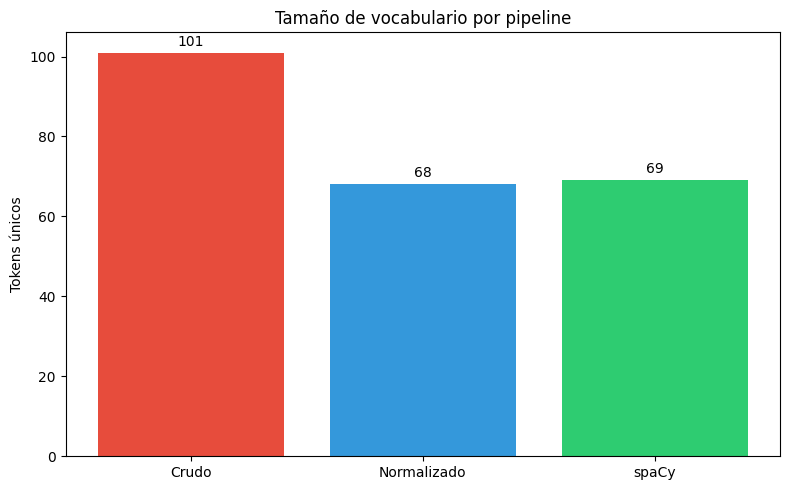

In [30]:

import matplotlib.pyplot as plt

# Gráfico Tamaño de vocabularios
fig, ax = plt.subplots(figsize=(8, 5))
pipelines = ['Crudo', 'Normalizado', 'spaCy']
vocab_sizes = [len(vocab_crudo), len(vocab_norm), len(vocab_spacy)]

bars = ax.bar(pipelines, vocab_sizes, color=['#e74c3c', '#3498db', '#2ecc71'])
ax.set_ylabel('Tokens únicos')
ax.set_title('Tamaño de vocabulario por pipeline')

# Agregar valores en las barras
for bar, size in zip(bars, vocab_sizes):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
            str(size), ha='center', va='bottom')

plt.tight_layout()
plt.savefig('out/vocab_sizes.png')
plt.show()

In [31]:
# Tabla resumen de métricas
import pandas as pd

tabla_metricas = pd.DataFrame({
    'Pipeline': ['Crudo', 'Normalizado', 'spaCy'],
    'Vocab Size': [len(vocab_crudo), len(vocab_norm), len(vocab_spacy)],
    'OOV Rate (%)': [oov_rate_crudo, oov_rate_norm, oov_rate_spacy],
    'Tokens totales': [len(tokens_crudo), len(tokens_norm), len(tokens_spacy)]
})

print("\nTabla de métricas:")
print(tabla_metricas.to_string(index=False))

# Guardar tabla
tabla_metricas.to_csv('out/tabla_metricas.csv', index=False)
print("\nTabla guardada: out/tabla_metricas.csv")


Tabla de métricas:
   Pipeline  Vocab Size  OOV Rate (%)  Tokens totales
      Crudo         101           0.0           40140
Normalizado          68           0.0           40140
      spaCy          69           0.0           40140

Tabla guardada: out/tabla_metricas.csv


# Preguntas teóricas

## 1. Stemming vs. Lematización

**Stemming** corta el final de las palabras sin entender gramática. 
Ej corta sufijos y prefijos
Es rápido pero tosco. Por ejemplo: "corriendo" → "corr" (corta el -iendo). Ojo que a veces produce palabras que no existen.

**Lematización** usa un diccionario y reglas gramaticales para encontrar la raíz real. Es más lento pero preciso. Por ejemplo: "corriendo" → "correr" (encuentra el verbo base). por eso usamos spaCy, porque lo hace para el español.

## 2. Impacto de segmentación en OOV

Una buena segmentación (dividir texto en palabras) reduce el OOV porque:
- Separa correctamente las palabras pegadas
- Identifica palabras compuestas
- Maneja bien la puntuación

Si segmentas mal (ejemplo: "no-entiendo" como una sola palabra), aumenta el OOV porque esa combinación exacta probablemente no la viste en entrenamiento.

## 3. Riesgos de normalización agresiva

Normalizar demasiado puede borrar información importante:
- Quitar mayúsculas: pierdes nombres propios (Juan vs juan)
- Quitar acentos: cambias significado (si vs sí)
- Quitar puntuación: pierdes tono (¡genial! vs genial)
- Quitar números: pierdes cantidades y fechas

Para análisis de sentimientos esto es fatal porque "¡¡¡INCREÍBLE!!!" y "increible" expresan intensidades muy diferentes.

## 4. Estrategias para code-switching

Para manejar mezcla de idiomas:
- **Detección por diccionario**: Tener lista de términos técnicos en inglés y no procesarlos
- **Detección automática**: Usar librería como langdetect para cada palabra
- **Mantener forma original**: No lematizar palabras detectadas como inglés
- **Embeddings multilingües**: Usar modelos que entienden varios idiomas

En nuestro caso, spaCy español trata "embeddings" como palabra desconocida y la deja igual. Mejor sería detectarla como inglés y procesarla con reglas especiales.

## 5. Caso donde normalización degrade un modelo

**Ejemplo: Detector de spam en emails**

Si normalizas agresivamente:
- "GANA $$$$ AHORA!!!" → "gana ahora"
- "Estimado cliente" → "estimado cliente"

Ambos quedan iguales después de normalizar, pero el primero es claramente spam. Las mayúsculas excesivas, símbolos repetidos y puntuación son señales importantes de spam que perdiste al normalizar.

# Conclusiones

## Trade-offs encontrados

- **Pipeline crudo**: Mantiene toda la información pero vocabulario grande (101 tokens)
- **Pipeline normalizado**: Reduce vocabulario 33% (68 tokens) pero pierde información de mayúsculas/puntuación
- **Pipeline spaCy**: Similar reducción (69 tokens) pero más costoso computacionalmente

## Riesgos identificados

- Dataset muy repetitivo genera OOV=0% irreal
- spaCy no maneja bien términos técnicos en inglés
- Normalización excesiva puede dañar tareas de sentimientos o NER

## Next sprint

- Implementar detector de idioma para code-switching
- Probar con dataset más diverso (noticias, tweets)
- Comparar con stemmer tradicional (SnowballStemmer)
- Evaluar impacto en tarea downstream (clasificación)